In [1]:
import time
import brainstate
import braintools
import brainunit as u
import matplotlib.pyplot as plt
import jax.numpy as jnp
import braincell
import jax
import numpy as np
#jax.config.update("jax_disable_jit", True)
s = u.siemens / u.cm ** 2

In [2]:
class MultiCompartmentHH(braincell.MultiCompartment):
    def __init__(self,  size, connection, Ra, cm, diam, L, solver = 'exp_euler'):
        super().__init__(
            size=size,
            connection= connection,
            Ra= Ra * u.ohm * u.cm,
            cm= cm * u.uF / u.cm ** 2,
            diam=diam * u.um,
            L= L * u.um,
            V_th=20. * u.mV,
            V_initializer=brainstate.init.Constant(-65 * u.mV),
            spk_fun=brainstate.surrogate.ReluGrad(),
            solver = solver
        )
        self.IL = braincell.channel.IL(self.varshape, E= -65 * u.mV, g_max= 0.001 * s)
        
        '''
        self.na =  braincell.ion.SodiumFixed(self.varshape, E= 50. * u.mV)
        self.na.add(INa = INa(self.varshape, g_max= gna * u.mS / (u.cm ** 2)))

        self.k = braincell.ion.PotassiumFixed(self.varshape, E= -80. * u.mV)
        self.k.add(IK =IK(self.varshape, g_max= gk * u.mS / (u.cm ** 2)))
        '''

    def step_run(self, t, inp):
        with brainstate.environ.context(t=t):
            self.update(inp)
            return self.V.value

In [3]:
def run(size, connection, Ra, cm, diam, L, I, dt, solver):

    brainstate.environ.set(dt= dt * u.ms)
    times = u.math.arange(I.shape[0]) * brainstate.environ.get_dt()
    
    ## model
    neu = MultiCompartmentHH(size, connection, Ra, cm, diam, L, solver=solver)  
    neu.init_state()
    neu.reset_state()
 
    ## run
    t0 = time.time()
    vs = brainstate.compile.for_loop(neu.step_run, times, I)
    print(f"Elapsed time: {time.time() - t0:.4f} s")

    ## plot
    plt.plot(times.to_decimal(u.ms), u.math.squeeze(vs.to_decimal(u.mV)))
    plt.grid(True)
    #plt.savefig('voltage_vs_time.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return vs[:,:,0].to_decimal(u.mV)

In [4]:
def Input(num_input_stage, num_compartment, dt):
    
    brainstate.environ.set(dt=dt * u.ms)
    value = jnp.zeros((num_input_stage, num_compartment))
    value = value.at[0, 0].set(0.01)
    value = value.at[1, 0].set(0.01)
    value = value.at[2, 0].set(0.00)

    I = braintools.input.section_input(values=value, durations=[5 * u.ms, 5 * u.ms, 10 * u.ms]) * u.uA
    
    return I

def con_line(num_compartment):
    connection = [[i, i + 1] for i in range(num_compartment - 1)]
    return connection

def con_star(num_compartment):
    connection = [[0, i + 1] for i in range(num_compartment - 1)]
    return connection


In [5]:
def param(num): 
    num = num
    size = (1, num)
    connection = con_line(num)
    Ra = 100 * np.ones(num)
    cm = 1 * np.ones(num)
    diam = 10 * np.ones(num)
    L = 500 * np.ones(num)
    L[0] = 10
    dt = 0.01
    return size, connection, Ra, cm, diam, L, dt

In [6]:
def compare(num, solver_1, solver_2):
    size, connection, Ra, cm, diam, L, dt = param(num)
    I = Input(3, num, dt)
    v1 = run(size, connection, Ra, cm, diam, L, I, dt , solver_1)
    v2 = run(size, connection, Ra, cm, diam, L, I, dt  , solver_2)
    
    return v1, v2

Elapsed time: 0.6785 s


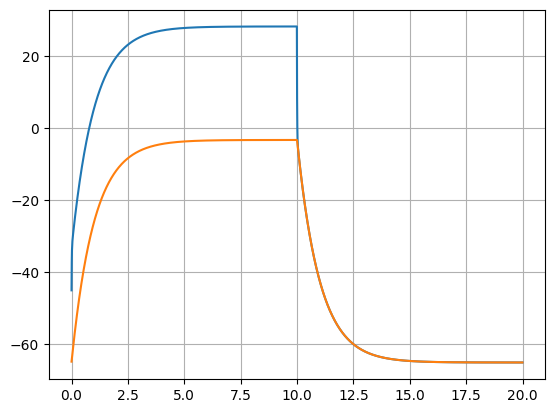

Elapsed time: 2.2896 s


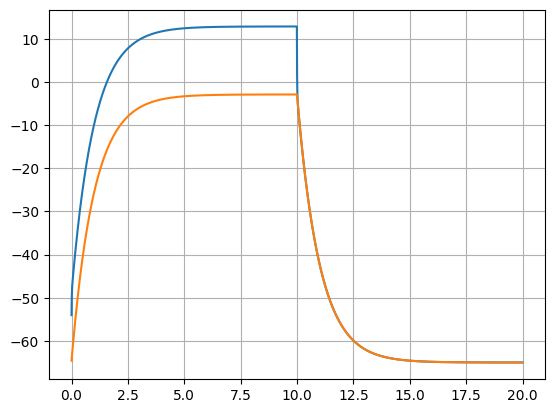

Elapsed time: 0.6119 s


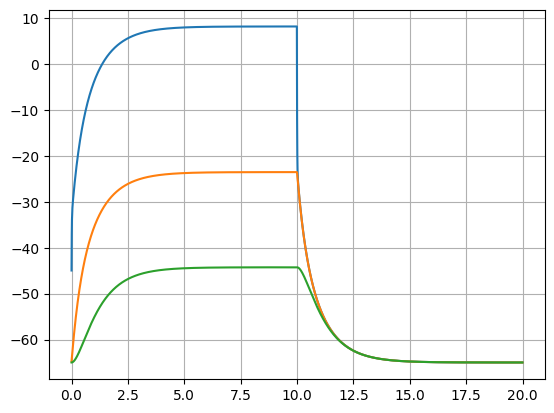

Elapsed time: 1.8614 s


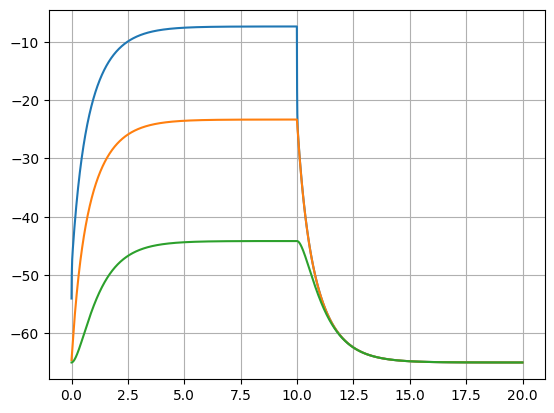

Elapsed time: 0.5523 s


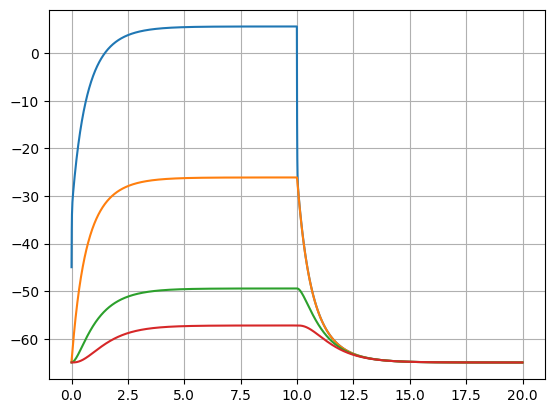

Elapsed time: 2.0707 s


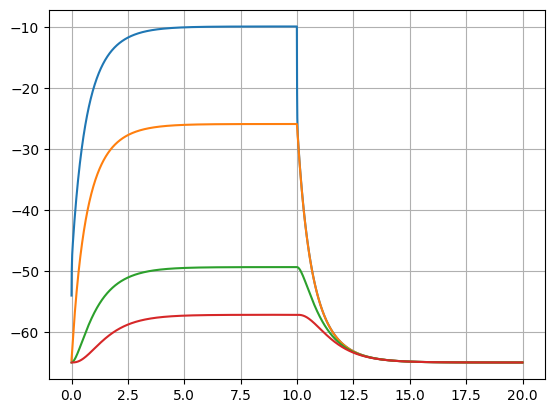

Elapsed time: 0.5604 s


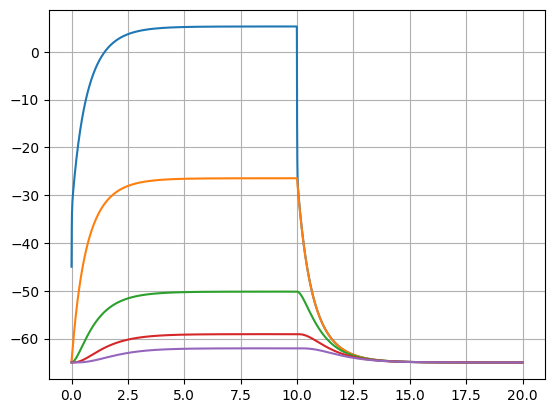

Elapsed time: 2.4348 s


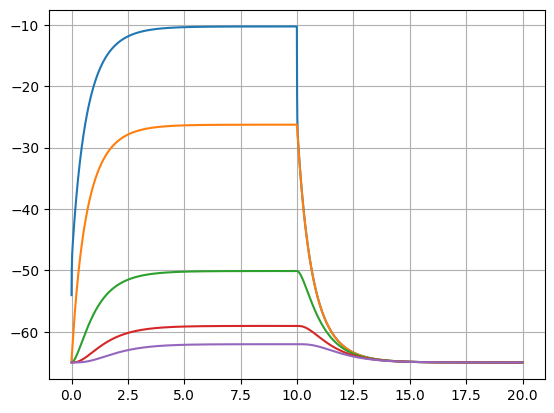

Elapsed time: 0.5798 s


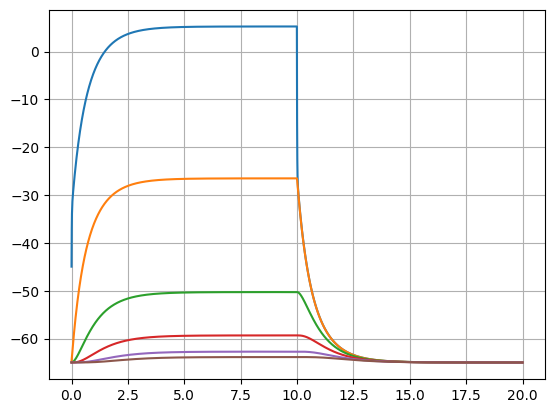

Elapsed time: 2.6978 s


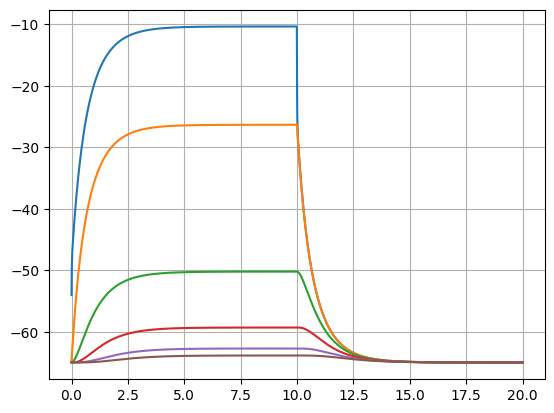

Elapsed time: 0.5557 s


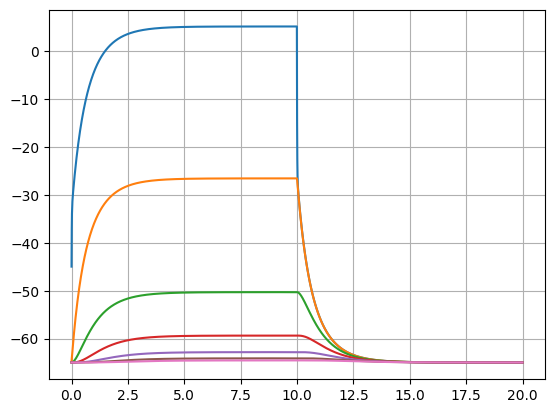

Elapsed time: 3.1256 s


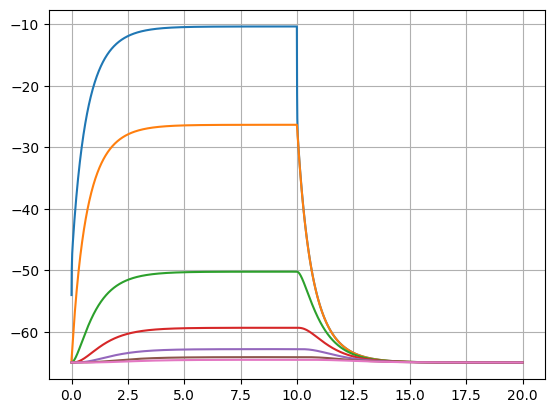

Elapsed time: 0.5394 s


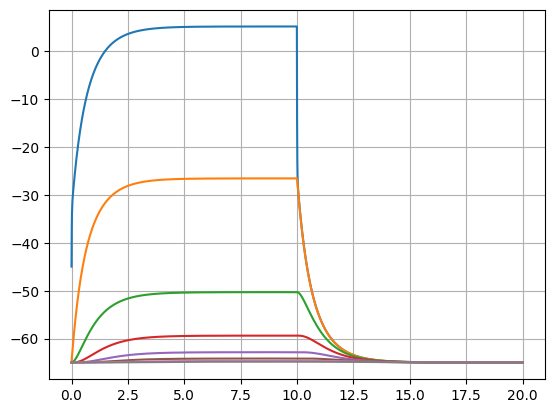

Elapsed time: 3.6202 s


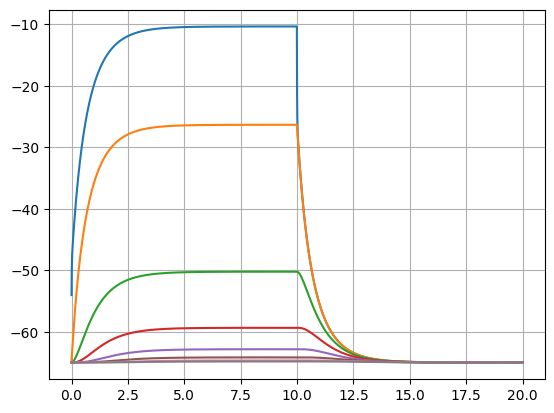

Elapsed time: 0.5767 s


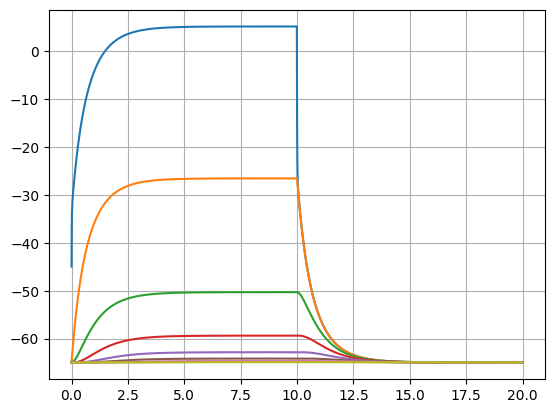

Elapsed time: 4.0699 s


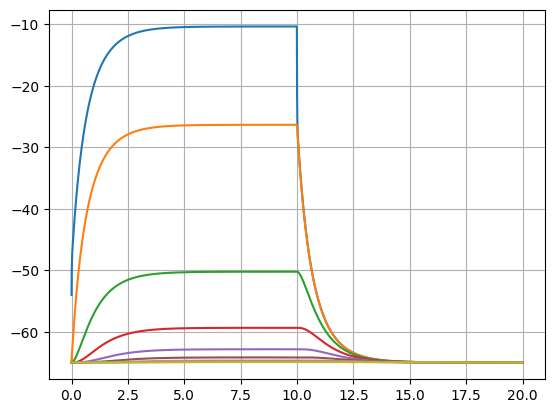

Elapsed time: 0.5675 s


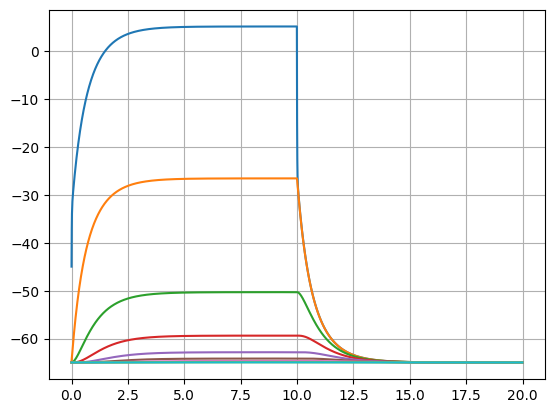

Elapsed time: 4.7152 s


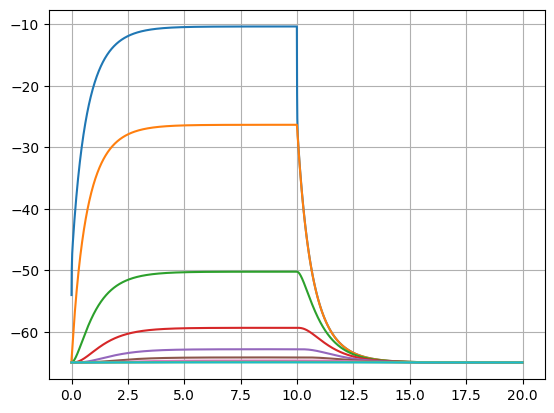

Elapsed time: 0.5448 s


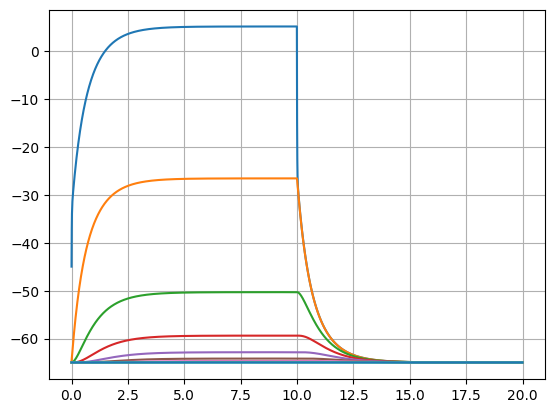

Elapsed time: 5.3117 s


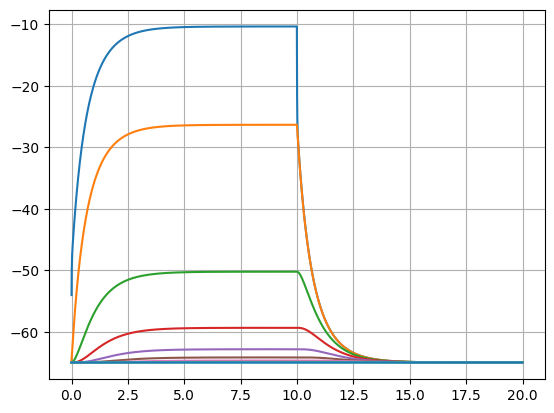

Elapsed time: 0.5610 s


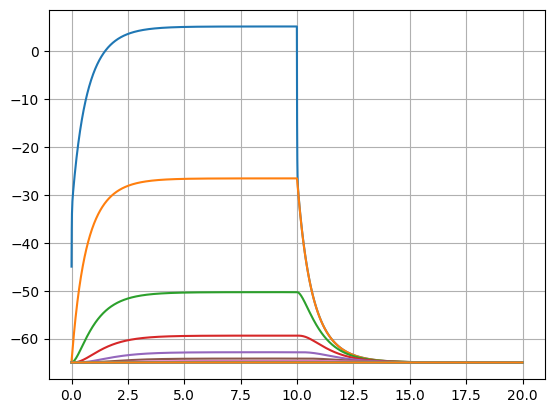

In [ ]:
error_inf_list = []
v1_max = []
v2_max = []

for i in range(2,21):
    v1, v2 = compare(i,'rk4','splitting')
    v1_max.append(np.max(v1))
    v2_max.append(np.max(v2))
    
    error_inf =  np.linalg.norm(v1 - v2, np.inf)
    error_inf_list.append(error_inf)

In [ ]:
np.abs(np.array(v1_max) - np.array(v2_max))


array([15.449043, 15.549732, 15.562506, 15.564333, 15.564629, 15.564644,
       15.564652, 15.564655, 15.564656, 15.564663, 15.564665, 15.564665,
       15.564665, 15.564665, 15.564652, 15.564665, 15.564665, 15.564665,
       15.564665], dtype=float32)

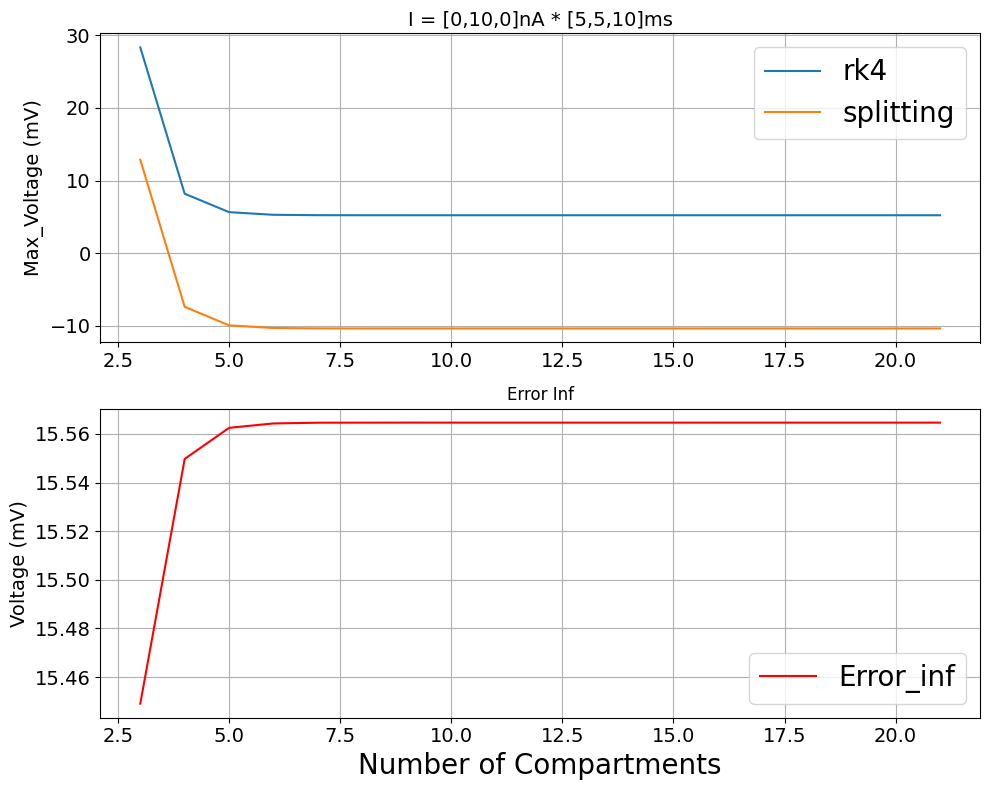

In [ ]:
from matplotlib.font_manager import FontProperties
num_compartment = np.arange(3,22)
# 创建一个包含2行1列子图的图形
fig, axes = plt.subplots(2, 1, figsize=(10, 8))
legend_font = FontProperties(size=20)
# 第一个子图，绘制 v1_max 和 v2_max 曲线
axes[0].plot(num_compartment, v1_max, label='rk4')
axes[0].plot(num_compartment, v2_max, label='splitting')
axes[0].set_title('I = [0,10,0]nA * [5,5,10]ms',fontsize=14)
axes[0].set_ylabel('Max_Voltage (mV)',fontsize=14)
axes[0].legend(prop=legend_font)
axes[0].grid(True)
# 设置第一个子图 x 轴和 y 轴刻度标签的字体大小
axes[0].tick_params(axis='x', labelsize=14)
axes[0].tick_params(axis='y', labelsize=14)


axes[1].plot(num_compartment, error_inf_list, label='Error_inf', color='red')
axes[1].set_title('Error Inf')
axes[1].set_xlabel('Number of Compartments',fontsize=20)
axes[1].set_ylabel('Voltage (mV)',fontsize=14)
axes[1].legend(prop=legend_font)
axes[1].grid(True)


axes[1].tick_params(axis='x', labelsize=14)
axes[1].tick_params(axis='y', labelsize=14)

plt.tight_layout()

plt.show()